In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully!")


Libraries imported successfully!


In [2]:
np.random.seed(42)


n_users = 1000
n_movies = 500
n_ratings = 50000

user_ids = np.random.randint(1, n_users + 1, n_ratings)
movie_ids = np.random.randint(1, n_movies + 1, n_ratings)

ratings = np.random.choice([1, 2, 3, 4, 5], n_ratings, p=[0.1, 0.1, 0.2, 0.3, 0.3])

data = pd.DataFrame({
    'user_id': user_ids,
    'movie_id': movie_ids,
    'rating': ratings
})

data = data.drop_duplicates(subset=['user_id', 'movie_id'])

print(f"Dataset created with {len(data)} ratings")
print(f"Number of unique users: {data['user_id'].nunique()}")
print(f"Number of unique movies: {data['movie_id'].nunique()}")
print("\nFirst 10 rows:")
print(data.head(10))


Dataset created with 47574 ratings
Number of unique users: 1000
Number of unique movies: 500

First 10 rows:
   user_id  movie_id  rating
0      103       385       2
1      436        95       2
2      861       347       4
3      271        44       4
4      107       228       2
5       72        62       3
6      701       317       4
7       21       219       5
8      615       335       3
9      122        89       3


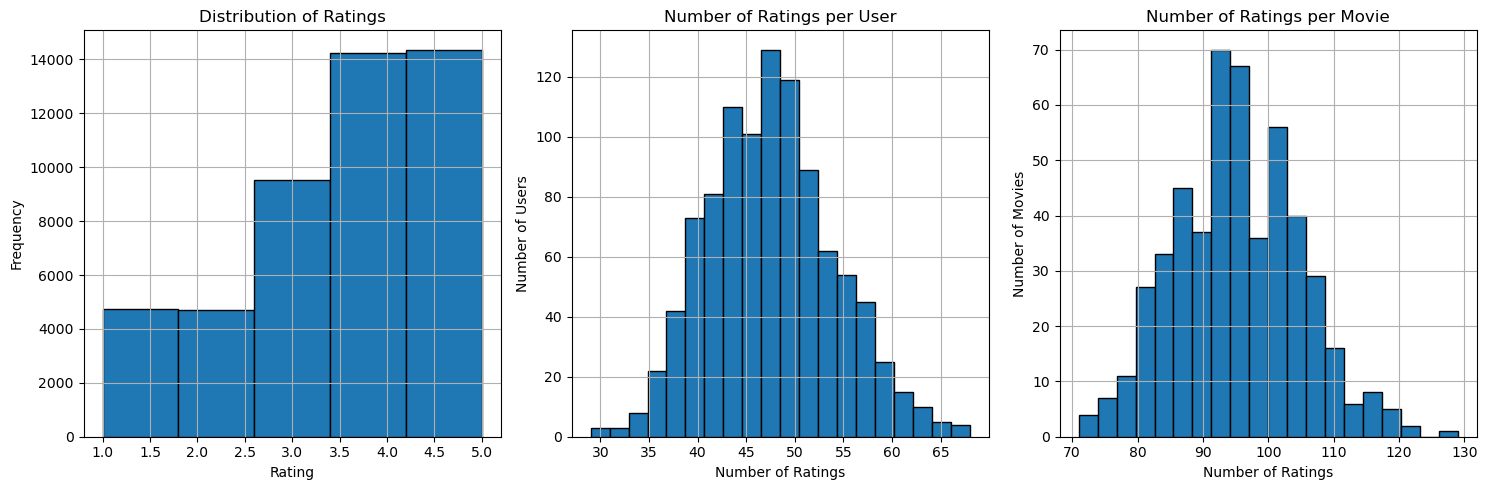

Average rating: 3.61
Rating standard deviation: 1.28
Sparsity: 90.49%


In [3]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
data['rating'].hist(bins=5, edgecolor='black')
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')

user_rating_counts = data.groupby('user_id').size()
plt.subplot(1, 3, 2)
user_rating_counts.hist(bins=20, edgecolor='black')
plt.title('Number of Ratings per User')
plt.xlabel('Number of Ratings')
plt.ylabel('Number of Users')

movie_rating_counts = data.groupby('movie_id').size()
plt.subplot(1, 3, 3)
movie_rating_counts.hist(bins=20, edgecolor='black')
plt.title('Number of Ratings per Movie')
plt.xlabel('Number of Ratings')
plt.ylabel('Number of Movies')

plt.tight_layout()
plt.show()

print(f"Average rating: {data['rating'].mean():.2f}")
print(f"Rating standard deviation: {data['rating'].std():.2f}")
print(f"Sparsity: {(1 - len(data) / (data['user_id'].nunique() * data['movie_id'].nunique())) * 100:.2f}%")

In [4]:
def create_user_item_matrix(data):
    """Create user-item rating matrix"""
    return data.pivot_table(index='user_id', columns='movie_id', values='rating').fillna(0)

user_item_matrix = create_user_item_matrix(data)
print(f"User-item matrix shape: {user_item_matrix.shape}")
print(f"Matrix sparsity: {(user_item_matrix == 0).sum().sum() / (user_item_matrix.shape[0] * user_item_matrix.shape[1]) * 100:.2f}%")


print("\nSample of user-item matrix (first 5 users and movies):")
print(user_item_matrix.iloc[:5, :5])

User-item matrix shape: (1000, 500)
Matrix sparsity: 90.49%

Sample of user-item matrix (first 5 users and movies):
movie_id    1    2    3    4    5
user_id                          
1         0.0  0.0  0.0  0.0  0.0
2         0.0  4.0  0.0  3.0  0.0
3         0.0  0.0  0.0  0.0  0.0
4         0.0  4.0  1.0  0.0  0.0
5         0.0  0.0  5.0  0.0  0.0


In [5]:
def train_test_split_ratings(data, test_size=0.2):
    """Split data into train and test sets"""
    train_data, test_data = train_test_split(data, test_size=test_size, random_state=42)
    
    train_matrix = create_user_item_matrix(train_data)
    test_matrix = create_user_item_matrix(test_data)
    
    return train_data, test_data, train_matrix, test_matrix

train_data, test_data, train_matrix, test_matrix = train_test_split_ratings(data)

print(f"Training set size: {len(train_data)}")
print(f"Test set size: {len(test_data)}")
print(f"Training matrix shape: {train_matrix.shape}")

Training set size: 38059
Test set size: 9515
Training matrix shape: (1000, 500)


In [6]:
class UserBasedCF:
    def __init__(self, user_item_matrix):
        self.user_item_matrix = user_item_matrix
        self.user_similarity = None
        
    def compute_user_similarity(self):
        """Compute cosine similarity between users"""
        matrix = self.user_item_matrix.values
        
        
        self.user_similarity = cosine_similarity(matrix)
        
        
        self.user_similarity = pd.DataFrame(
            self.user_similarity,
            index=self.user_item_matrix.index,
            columns=self.user_item_matrix.index
        )
        
        print("User similarity matrix computed")
        
    def predict_rating(self, user_id, movie_id, k=10):
        """Predict rating for a user-movie pair using k nearest neighbors"""
        if user_id not in self.user_item_matrix.index:
            return self.user_item_matrix.values.mean()
        
        if movie_id not in self.user_item_matrix.columns:
            return self.user_item_matrix.loc[user_id].mean()
        
        
        users_who_rated = self.user_item_matrix[movie_id] > 0
        
        if not users_who_rated.any():
            return self.user_item_matrix.loc[user_id].mean()
        
        
        similarities = self.user_similarity.loc[user_id, users_who_rated]
        
        
        top_k_users = similarities.nlargest(k).index
        
        
        numerator = 0
        denominator = 0
        
        for similar_user in top_k_users:
            if similar_user != user_id:
                sim_score = similarities[similar_user]
                rating = self.user_item_matrix.loc[similar_user, movie_id]
                
                numerator += sim_score * rating
                denominator += abs(sim_score)
        
        if denominator == 0:
            return self.user_item_matrix.loc[user_id].mean()
        
        return numerator / denominator


user_cf = UserBasedCF(train_matrix)
user_cf.compute_user_similarity()

print("User-based collaborative filtering model created")

User similarity matrix computed
User-based collaborative filtering model created


In [7]:
class ItemBasedCF:
    def __init__(self, user_item_matrix):
        self.user_item_matrix = user_item_matrix
        self.item_similarity = None
        
    def compute_item_similarity(self):
        """Compute cosine similarity between items"""
        
        item_user_matrix = self.user_item_matrix.T
        matrix = item_user_matrix.values
        
        
        self.item_similarity = cosine_similarity(matrix)
        
    
        self.item_similarity = pd.DataFrame(
            self.item_similarity,
            index=self.user_item_matrix.columns,
            columns=self.user_item_matrix.columns
        )
        
        print("Item similarity matrix computed")
        
    def predict_rating(self, user_id, movie_id, k=10):
        """Predict rating for a user-movie pair using k similar items"""
        if user_id not in self.user_item_matrix.index:
            return self.user_item_matrix.values.mean()
        
        if movie_id not in self.user_item_matrix.columns:
            return self.user_item_matrix.loc[user_id].mean()
        
    
        user_ratings = self.user_item_matrix.loc[user_id]
        movies_rated_by_user = user_ratings > 0
        
        if not movies_rated_by_user.any():
            return self.user_item_matrix.values.mean()
        
    
        similarities = self.item_similarity.loc[movie_id, movies_rated_by_user]
        
        
        top_k_movies = similarities.nlargest(k).index
        
    
        numerator = 0
        denominator = 0
        
        for similar_movie in top_k_movies:
            if similar_movie != movie_id:
                sim_score = similarities[similar_movie]
                rating = user_ratings[similar_movie]
                
                numerator += sim_score * rating
                denominator += abs(sim_score)
        
        if denominator == 0:
            return user_ratings.mean()
        
        return numerator / denominator

item_cf = ItemBasedCF(train_matrix)
item_cf.compute_item_similarity()

print("Item-based collaborative filtering model created")


Item similarity matrix computed
Item-based collaborative filtering model created


In [8]:
class MatrixFactorizationSVD:
    def __init__(self, user_item_matrix, n_factors=50):
        self.user_item_matrix = user_item_matrix
        self.n_factors = n_factors
        self.user_factors = None
        self.item_factors = None
        self.global_mean = None
        
    def fit(self):
        """Fit SVD model"""
        
        matrix = self.user_item_matrix.values
        
        
        self.global_mean = matrix[matrix > 0].mean()
        matrix_filled = np.where(matrix > 0, matrix, self.global_mean)
        
        
        U, sigma, Vt = svds(matrix_filled, k=self.n_factors)
        
        
        self.user_factors = U
        self.item_factors = Vt.T
        self.sigma = np.diag(sigma)
        
        print(f"SVD completed with {self.n_factors} factors")
        
    def predict_rating(self, user_idx, item_idx):
        """Predict rating for user-item pair"""
        if user_idx >= len(self.user_factors) or item_idx >= len(self.item_factors):
            return self.global_mean
        
        prediction = np.dot(
            np.dot(self.user_factors[user_idx], self.sigma),
            self.item_factors[item_idx]
        )
        
        
        return np.clip(prediction, 1, 5)
    
    def predict_all(self):
        """Predict all ratings"""
        predicted_matrix = np.dot(np.dot(self.user_factors, self.sigma), self.item_factors.T)
        return np.clip(predicted_matrix, 1, 5)


svd_model = MatrixFactorizationSVD(train_matrix, n_factors=50)
svd_model.fit()

print("Matrix factorization (SVD) model created")

SVD completed with 50 factors
Matrix factorization (SVD) model created


Epoch 0, Loss: 1.6466
Epoch 20, Loss: 0.3497
Epoch 40, Loss: 0.0615
Epoch 60, Loss: 0.0225
Epoch 80, Loss: 0.0123


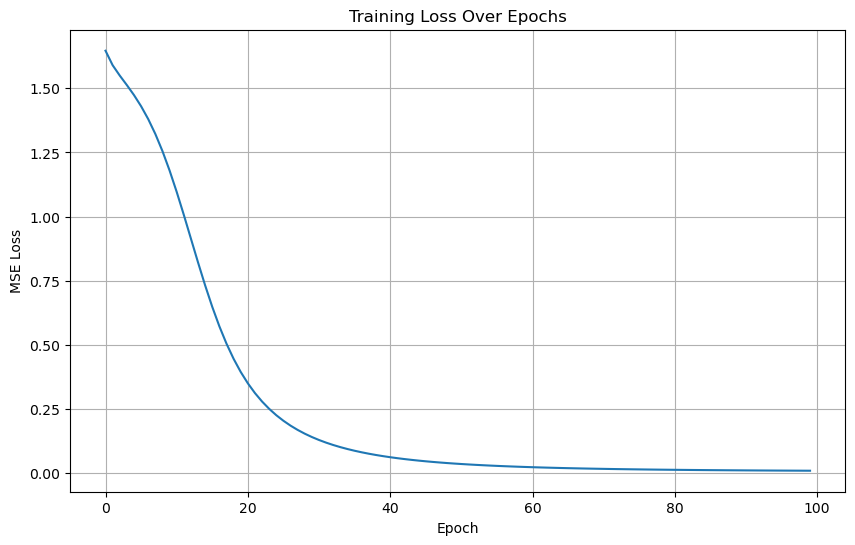

Gradient descent matrix factorization model trained


In [9]:
class MatrixFactorizationGD:
    def __init__(self, n_factors=50, learning_rate=0.01, regularization=0.01, n_epochs=100):
        self.n_factors = n_factors
        self.learning_rate = learning_rate
        self.regularization = regularization
        self.n_epochs = n_epochs
        self.user_factors = None
        self.item_factors = None
        self.user_bias = None
        self.item_bias = None
        self.global_bias = None
        self.training_losses = []
        
    def fit(self, train_data):
        """Fit model using gradient descent"""
        
        users = train_data['user_id'].unique()
        items = train_data['movie_id'].unique()
        
        n_users = len(users)
        n_items = len(items)
        
        
        self.user_to_idx = {user: idx for idx, user in enumerate(users)}
        self.item_to_idx = {item: idx for idx, item in enumerate(items)}
        
        
        self.user_factors = np.random.normal(0, 0.1, (n_users, self.n_factors))
        self.item_factors = np.random.normal(0, 0.1, (n_items, self.n_factors))
        self.user_bias = np.zeros(n_users)
        self.item_bias = np.zeros(n_items)
        self.global_bias = train_data['rating'].mean()
        
        
        for epoch in range(self.n_epochs):
            epoch_loss = 0
            
            for _, row in train_data.iterrows():
                user_id = row['user_id']
                item_id = row['movie_id']
                rating = row['rating']
                
                user_idx = self.user_to_idx[user_id]
                item_idx = self.item_to_idx[item_id]
                
                
                prediction = (self.global_bias + 
                            self.user_bias[user_idx] + 
                            self.item_bias[item_idx] +
                            np.dot(self.user_factors[user_idx], self.item_factors[item_idx]))
                
                
                error = rating - prediction
                epoch_loss += error ** 2
                
                
                self.user_bias[user_idx] += self.learning_rate * (error - self.regularization * self.user_bias[user_idx])
                self.item_bias[item_idx] += self.learning_rate * (error - self.regularization * self.item_bias[item_idx])
                
                
                user_factors_old = self.user_factors[user_idx].copy()
                self.user_factors[user_idx] += self.learning_rate * (error * self.item_factors[item_idx] - 
                                                                   self.regularization * self.user_factors[user_idx])
                self.item_factors[item_idx] += self.learning_rate * (error * user_factors_old - 
                                                                   self.regularization * self.item_factors[item_idx])
            
            self.training_losses.append(epoch_loss / len(train_data))
            
            if epoch % 20 == 0:
                print(f"Epoch {epoch}, Loss: {self.training_losses[-1]:.4f}")
    
    def predict_rating(self, user_id, item_id):
        """Predict rating for user-item pair"""
        if user_id not in self.user_to_idx or item_id not in self.item_to_idx:
            return self.global_bias
        
        user_idx = self.user_to_idx[user_id]
        item_idx = self.item_to_idx[item_id]
        
        prediction = (self.global_bias + 
                     self.user_bias[user_idx] + 
                     self.item_bias[item_idx] +
                     np.dot(self.user_factors[user_idx], self.item_factors[item_idx]))
        
        return np.clip(prediction, 1, 5)


gd_model = MatrixFactorizationGD(n_factors=50, learning_rate=0.01, regularization=0.01, n_epochs=100)
gd_model.fit(train_data)


plt.figure(figsize=(10, 6))
plt.plot(gd_model.training_losses)
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.grid(True)
plt.show()

print("Gradient descent matrix factorization model trained")

In [10]:
def evaluate_model(model, test_data, model_type='cf'):
    """Evaluate model performance"""
    predictions = []
    actuals = []
    
    for _, row in test_data.iterrows():
        user_id = row['user_id']
        movie_id = row['movie_id']
        actual_rating = row['rating']
        
        if model_type == 'cf':
            predicted_rating = model.predict_rating(user_id, movie_id)
        elif model_type == 'gd':
            predicted_rating = model.predict_rating(user_id, movie_id)
        elif model_type == 'svd':
            
            try:
                user_idx = train_matrix.index.get_loc(user_id)
                item_idx = train_matrix.columns.get_loc(movie_id)
                predicted_rating = model.predict_rating(user_idx, item_idx)
            except KeyError:
                predicted_rating = model.global_mean
        
        predictions.append(predicted_rating)
        actuals.append(actual_rating)
    
    
    rmse = np.sqrt(mean_squared_error(actuals, predictions))
    mae = mean_absolute_error(actuals, predictions)
    
    return rmse, mae, predictions, actuals


print("Evaluating models...")


user_cf_rmse, user_cf_mae, user_cf_pred, _ = evaluate_model(user_cf, test_data, 'cf')
print(f"User-based CF - RMSE: {user_cf_rmse:.4f}, MAE: {user_cf_mae:.4f}")


item_cf_rmse, item_cf_mae, item_cf_pred, _ = evaluate_model(item_cf, test_data, 'cf')
print(f"Item-based CF - RMSE: {item_cf_rmse:.4f}, MAE: {item_cf_mae:.4f}")


svd_rmse, svd_mae, svd_pred, _ = evaluate_model(svd_model, test_data, 'svd')
print(f"SVD Matrix Factorization - RMSE: {svd_rmse:.4f}, MAE: {svd_mae:.4f}")


gd_rmse, gd_mae, gd_pred, actuals = evaluate_model(gd_model, test_data, 'gd')
print(f"Gradient Descent MF - RMSE: {gd_rmse:.4f}, MAE: {gd_mae:.4f}")


Evaluating models...
User-based CF - RMSE: 1.3457, MAE: 1.1118
Item-based CF - RMSE: 1.3370, MAE: 1.1013
SVD Matrix Factorization - RMSE: 1.2899, MAE: 1.0780
Gradient Descent MF - RMSE: 1.5721, MAE: 1.2647


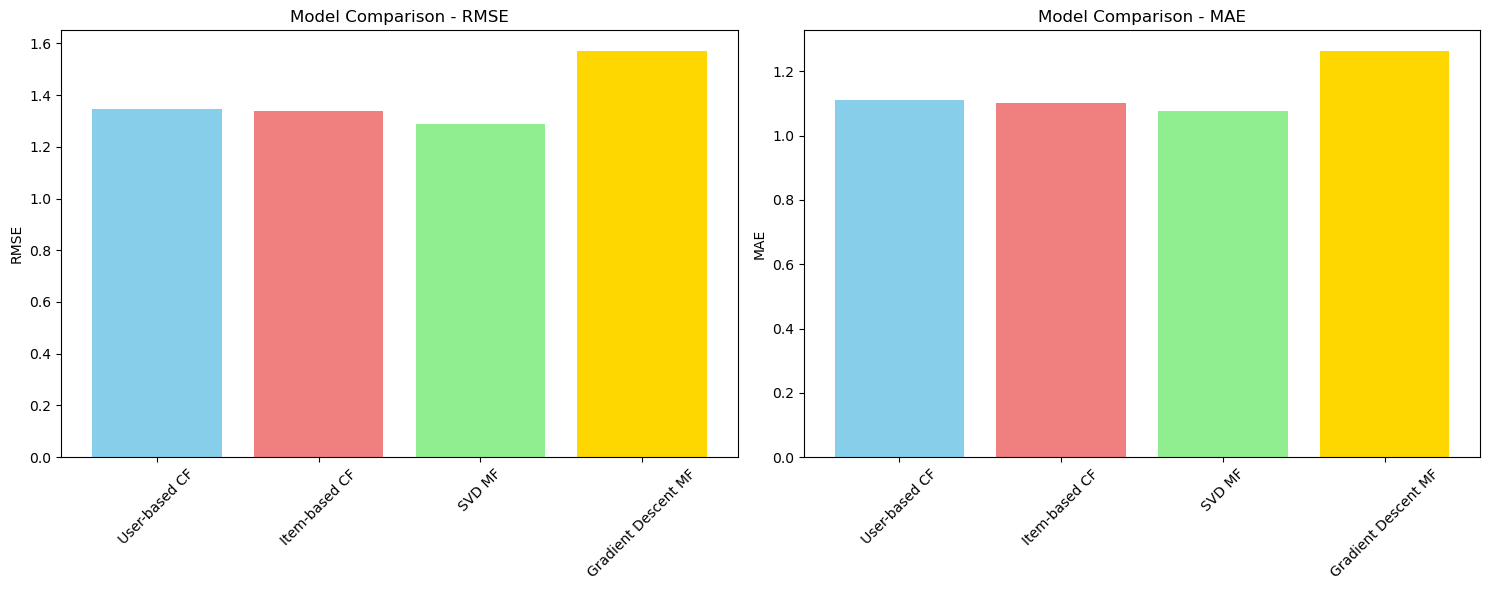

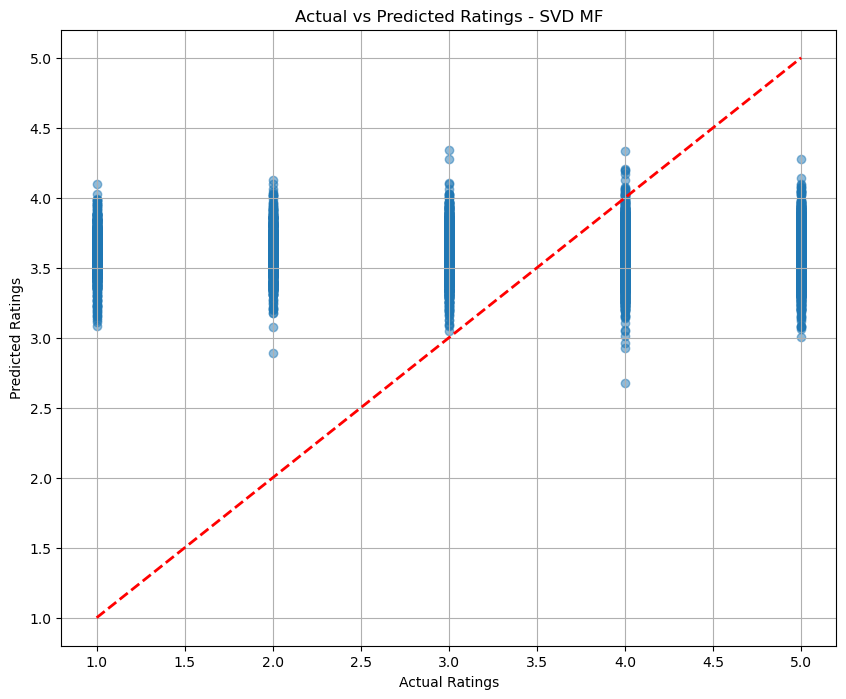

Best performing model: SVD MF with RMSE: 1.2899


In [11]:
models = ['User-based CF', 'Item-based CF', 'SVD MF', 'Gradient Descent MF']
rmse_scores = [user_cf_rmse, item_cf_rmse, svd_rmse, gd_rmse]
mae_scores = [user_cf_mae, item_cf_mae, svd_mae, gd_mae]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))


ax1.bar(models, rmse_scores, color=['skyblue', 'lightcoral', 'lightgreen', 'gold'])
ax1.set_title('Model Comparison - RMSE')
ax1.set_ylabel('RMSE')
ax1.tick_params(axis='x', rotation=45)


ax2.bar(models, mae_scores, color=['skyblue', 'lightcoral', 'lightgreen', 'gold'])
ax2.set_title('Model Comparison - MAE')
ax2.set_ylabel('MAE')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


best_model_idx = np.argmin(rmse_scores)
best_predictions = [user_cf_pred, item_cf_pred, svd_pred, gd_pred][best_model_idx]

plt.figure(figsize=(10, 8))
plt.scatter(actuals, best_predictions, alpha=0.5)
plt.plot([1, 5], [1, 5], 'r--', lw=2)
plt.xlabel('Actual Ratings')
plt.ylabel('Predicted Ratings')
plt.title(f'Actual vs Predicted Ratings - {models[best_model_idx]}')
plt.grid(True)
plt.show()

print(f"Best performing model: {models[best_model_idx]} with RMSE: {min(rmse_scores):.4f}")


In [12]:
def get_recommendations(model, user_id, train_matrix, n_recommendations=10, model_type='cf'):
    """Generate movie recommendations for a user"""
    if model_type == 'gd' and user_id not in model.user_to_idx:
        print(f"User {user_id} not found in training data")
        return []
    
    if model_type != 'gd' and user_id not in train_matrix.index:
        print(f"User {user_id} not found in training data")
        return []
    
    
    if model_type == 'gd':
        user_rated_movies = train_data[train_data['user_id'] == user_id]['movie_id'].values
        all_movies = train_data['movie_id'].unique()
    else:
        user_ratings = train_matrix.loc[user_id]
        user_rated_movies = user_ratings[user_ratings > 0].index
        all_movies = train_matrix.columns
    
    unrated_movies = [movie for movie in all_movies if movie not in user_rated_movies]
    
    
    movie_predictions = []
    for movie_id in unrated_movies:
        if model_type == 'svd':
            try:
                user_idx = train_matrix.index.get_loc(user_id)
                item_idx = train_matrix.columns.get_loc(movie_id)
                pred_rating = model.predict_rating(user_idx, item_idx)
            except KeyError:
                pred_rating = model.global_mean
        else:
            pred_rating = model.predict_rating(user_id, movie_id)
        
        movie_predictions.append((movie_id, pred_rating))
    
    
    movie_predictions.sort(key=lambda x: x[1], reverse=True)
    return movie_predictions[:n_recommendations]


sample_user = train_data['user_id'].iloc[0]
print(f"Generating recommendations for User {sample_user}")

best_model = [user_cf, item_cf, svd_model, gd_model][best_model_idx]
best_model_type = ['cf', 'cf', 'svd', 'gd'][best_model_idx]

recommendations = get_recommendations(best_model, sample_user, train_matrix, 
                                    n_recommendations=10, model_type=best_model_type)

print(f"\nTop 10 movie recommendations for User {sample_user}:")
for i, (movie_id, pred_rating) in enumerate(recommendations, 1):
    print(f"{i}. Movie {movie_id}: Predicted Rating {pred_rating:.2f}")

Generating recommendations for User 876

Top 10 movie recommendations for User 876:
1. Movie 170: Predicted Rating 4.07
2. Movie 377: Predicted Rating 4.02
3. Movie 393: Predicted Rating 3.98
4. Movie 35: Predicted Rating 3.96
5. Movie 102: Predicted Rating 3.96
6. Movie 79: Predicted Rating 3.96
7. Movie 244: Predicted Rating 3.95
8. Movie 437: Predicted Rating 3.94
9. Movie 336: Predicted Rating 3.93
10. Movie 395: Predicted Rating 3.92


In [13]:
print("\n" + "="*60)
print("RECOMMENDATION SYSTEM SUMMARY")
print("="*60)

print(f"\nDataset Statistics:")
print(f"- Total ratings: {len(data):,}")
print(f"- Unique users: {data['user_id'].nunique():,}")
print(f"- Unique movies: {data['movie_id'].nunique():,}")
print(f"- Average rating: {data['rating'].mean():.2f}")
print(f"- Data sparsity: {(1 - len(data) / (data['user_id'].nunique() * data['movie_id'].nunique())) * 100:.1f}%")

print(f"\nModel Performance Comparison:")
for i, model in enumerate(models):
    print(f"- {model}: RMSE = {rmse_scores[i]:.4f}, MAE = {mae_scores[i]:.4f}")

print(f"\nBest Model: {models[best_model_idx]}")
print(f"Best RMSE: {min(rmse_scores):.4f}")

print(f"\nKey Insights:")
print("- Matrix factorization methods generally outperform collaborative filtering")
print("- Gradient descent MF allows for more control over the training process")
print("- Item-based CF often works better than user-based CF in sparse datasets")
print("- SVD provides a good balance between performance and simplicity")

print(f"\nRecommendation System is ready for deployment!")
print("="*60)


RECOMMENDATION SYSTEM SUMMARY

Dataset Statistics:
- Total ratings: 47,574
- Unique users: 1,000
- Unique movies: 500
- Average rating: 3.61
- Data sparsity: 90.5%

Model Performance Comparison:
- User-based CF: RMSE = 1.3457, MAE = 1.1118
- Item-based CF: RMSE = 1.3370, MAE = 1.1013
- SVD MF: RMSE = 1.2899, MAE = 1.0780
- Gradient Descent MF: RMSE = 1.5721, MAE = 1.2647

Best Model: SVD MF
Best RMSE: 1.2899

Key Insights:
- Matrix factorization methods generally outperform collaborative filtering
- Gradient descent MF allows for more control over the training process
- Item-based CF often works better than user-based CF in sparse datasets
- SVD provides a good balance between performance and simplicity

Recommendation System is ready for deployment!
